In [1]:
#Imports
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import scipy.optimize as opt

from tqdm import tqdm_notebook

import pint
import scipy.spatial as spa
import scipy.integrate as scint

idx = pd.IndexSlice
%matplotlib inline

from scipy.interpolate import make_interp_spline, BSpline

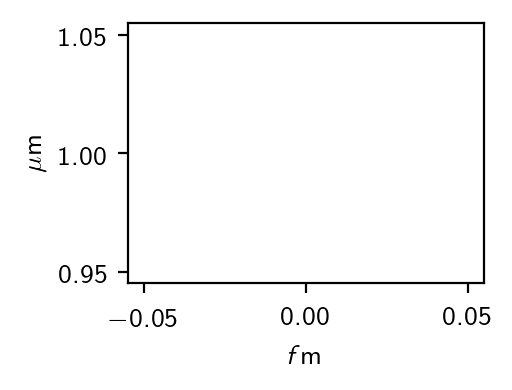

In [2]:
# From https://stackoverflow.com/questions/2537868/sans-serif-math-with-latex-in-matplotlib
plt.rc('text', usetex=True)
plt.rc('font', family='sans-serif')
mpl.rcParams['text.latex.preamble'] = [
       r'\usepackage{sansmath}',  # load up the sansmath so that math -> helvet
       r'\sansmath'               # <- tricky! -- gotta actually tell tex to use!
] 

mpl.rcParams.update({'figure.dpi': 200})

mpl.rcParams.update({'font.size': 10})

ureg = pint.UnitRegistry()
column = 18*ureg.cm

fig, ax = plt.subplots(1,1,figsize=(column-0.5*ureg.cm).to(ureg.inch).magnitude*np.array([1,0.75])/3)

plt.plot([0,0],[1,1])
plt.xlabel(r"$f$m")
plt.ylabel(r"$\mu$m");

In [42]:
#Loading the tracking matrix from csv file 
filePath = "Results_Test41_20190617.csv" #No coordinates, correct file is CurrentDensity
trj = pd.read_csv(filePath ,sep = "\t", index_col=0)
trj.head()

,x,y,frame,time,x0,y0,r,theta,theta_prime,theta_prime_unwrap,d_theta_prime,theta_dot_prime,theta_prime_interpol,theta_dot_prime_interpol,theta_dot_prime_integral,potential_landscape,data_fit
bins,,,,,,,,,,,,,,,,,
"(0.0, 0.00629]",335.720056,265.647984,6380.500000,106.342333,22.769493,26.964578,104.983870,0.550159,0.002856,-41.361447,-0.008091,-0.478156,0.002856,-0.478156,0.000000,0.022613,0.012842
"(0.00629, 0.0126]",350.064588,259.640350,5611.384615,93.523538,37.114025,20.956944,104.958772,0.354077,0.010429,-35.755395,-0.005004,-0.301368,0.010429,-0.301368,0.002952,0.020655,0.011012
"(0.0126, 0.0189]",344.256899,249.627285,5267.470588,87.791647,31.306336,10.943878,104.896106,0.300818,0.015796,-33.248126,-0.004487,-0.270087,0.015796,-0.270087,0.004485,0.018386,0.008762
"(0.0189, 0.0252]",338.298713,259.425272,6250.875000,104.181750,25.348150,20.741866,104.938351,0.451944,0.021629,-40.426376,-0.004203,-0.253013,0.021629,-0.253013,0.006011,0.015547,0.005762
"(0.0252, 0.0314]",355.577196,246.255015,6423.541667,107.059500,42.626634,7.571608,104.906230,0.263905,0.028670,-41.597432,-0.004024,-0.241538,0.028670,-0.241538,0.007752,0.013222,0.003235


lin fit slope =  0.6504748724687801 lin fit ind term =  -0.026444823300456534


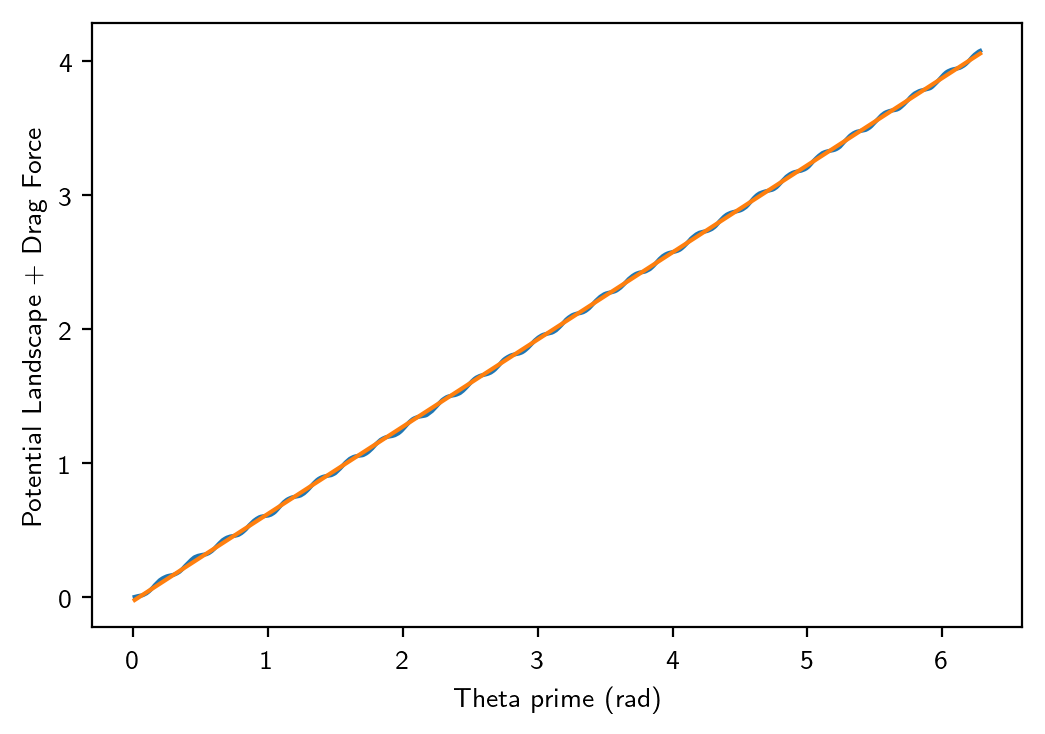

In [43]:
#interpolate the points where is no data to avoid problems integrating the function
theta_dot_prime_interpol = trj["theta_dot_prime"].interpolate()
theta_prime_interpol = trj["theta_prime"].interpolate()

I_trap = scint.cumtrapz(-theta_dot_prime_interpol, theta_prime_interpol)

x = np.array(theta_prime_interpol[1:])
data = np.array(I_trap)
lin_fit_trap = np.polyfit(x, data, 1)

rect = np.polyval(lin_fit_trap, x)

plt.plot(x, data)
plt.plot(x, rect)

plt.xlabel("Theta prime (rad)")
plt.ylabel("Potential Landscape + Drag Force")
#plt.xlim(-0.1,1)
#plt.ylim(-0.1,1)
print("lin fit slope = ", lin_fit_trap[0], "lin fit ind term = ", lin_fit_trap[1])

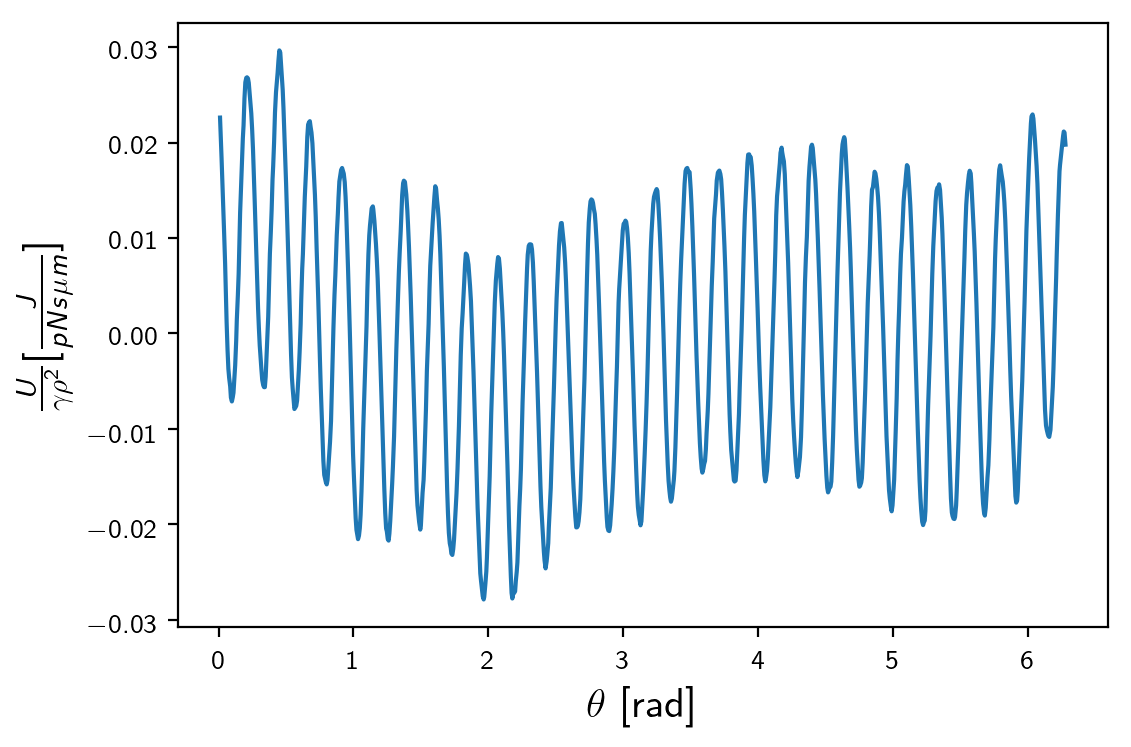

In [44]:
I_sim_rect = data-rect

plt.plot(x, I_sim_rect)#[:250])
plt.ylabel(r"$\frac{U}{\gamma \rho ^2} [\frac{J}{pN·s·\mu m}]$", fontfamily = "sans-serif", fontsize = 15)
plt.xlabel(r"$\theta$ [rad]", fontfamily = "sans-serif", fontsize = 15);

fit values: Amplitude =  0.017404942269989187 ; Frequency =  26.997708522077804 ; Phase =  2.03013194948514 ; Mean =  9.295614823414638e-16


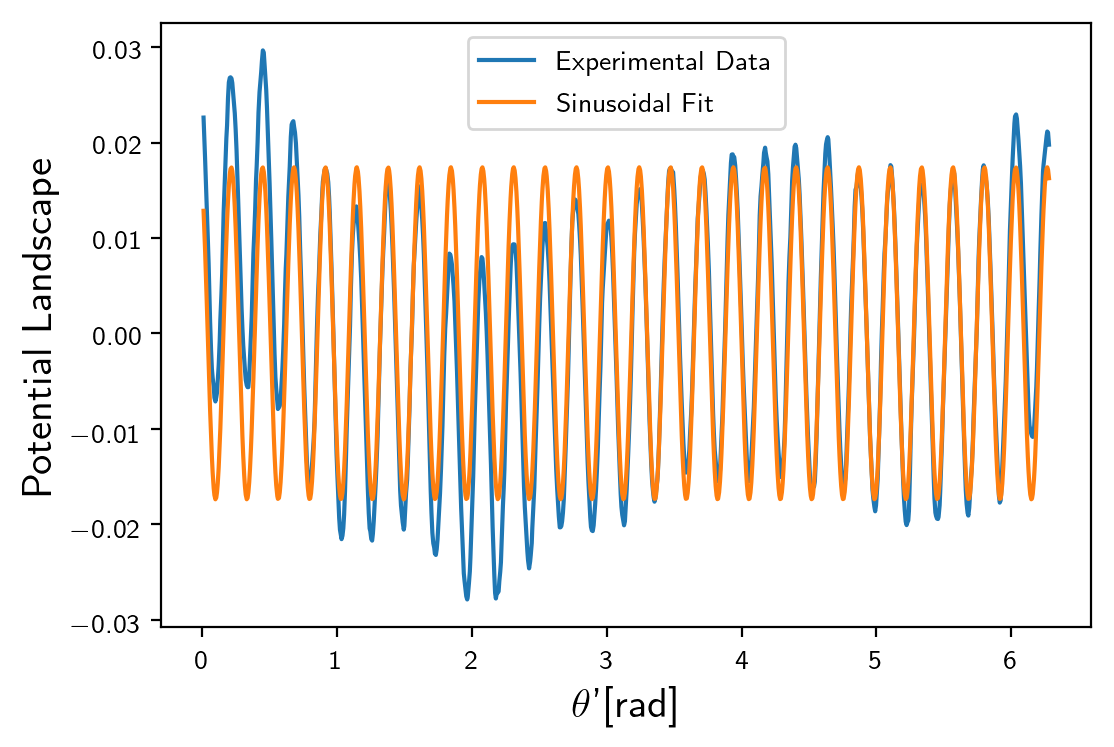

In [45]:
#estimation of the sinusoidal function prameters 
guess_mean = np.mean(I_sim_rect)
guess_std = 3*np.std(I_sim_rect)/(2**0.5)
guess_phase = 0
guess_freq = 27
guess_amp = 0.005

# we'll use this to plot our first estimate. This might already be good enough for you
data_first_guess = guess_std*np.sin(guess_freq*x+guess_phase) #+ guess_mean

# Define the function to optimize, in this case, we want to minimize the difference
# between the actual data and our "guessed" parameters
optimize_func = lambda y: y[0]*np.sin(y[1]*x+y[2]) + y[3] - I_sim_rect
est_amp, est_freq, est_phase, est_mean = opt.leastsq(optimize_func, [guess_amp, guess_freq, guess_phase, guess_mean])[0]

# recreate the fitted curve using the optimized parameters
data_fit = est_amp*np.sin(est_freq*x+est_phase) + est_mean

print('fit values: Amplitude = ', est_amp, '; Frequency = ', est_freq, '; Phase = ', est_phase, '; Mean = ', est_mean)

plt.plot(x, I_sim_rect, label='Experimental Data')#[:250])
plt.plot(x, data_fit, label='Sinusoidal Fit')
#plt.plot(t_grouped["theta_prime"][:len(I_sim_rect)], data_first_guess, '-', label='guess fit')
plt.ylabel("Potential Landscape", fontfamily="sans-serif",  fontsize=15)
plt.xlabel(r"$\theta$'[rad]", fontfamily="sans-serif",  fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
#plt.xlim(0.305, 0.545)
plt.legend();

# Construction of new DataFrame to save only information about Potential Landscape and the sinusoidal fit

In [47]:
dataset = pd.DataFrame()
dataset["Potential_Landscape"] = [x*19**2/0.1295 for x in I_sim_rect] #I_sim_rect*27.47**2
dataset["Position_Theta"] = x
dataset["Sinusoidal_Fit"] = data_fit*19**2/0.1295

dataset

,Potential_Landscape,Position_Theta,Sinusoidal_Fit
0,63.035707,0.010429,35.800313
1,57.578751,0.015796,30.696845
2,51.254351,0.021629,24.424050
3,43.340150,0.028670,16.062509
4,36.857221,0.034244,9.018373
5,29.084818,0.040923,0.322162
6,20.424655,0.048048,-8.959892
7,12.923629,0.053066,-15.318164
8,3.274510,0.059194,-22.690692
9,-4.974281,0.066211,-30.359982


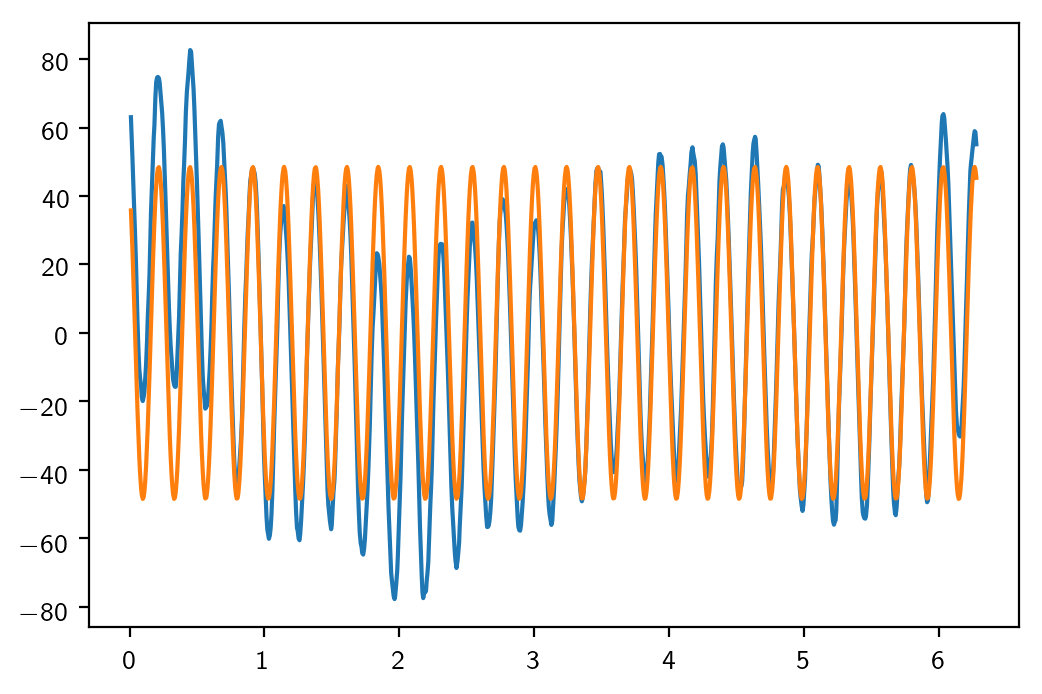

In [48]:
plt.plot(dataset.Position_Theta, dataset.Potential_Landscape)
plt.plot(dataset.Position_Theta, dataset.Sinusoidal_Fit)

In [49]:
dataset.to_csv("C:/Users/Eric/Desktop/Potential_Landscape_R09.dat", sep = "\t")